In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,compute_rbf_mmd_median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass

set_seed(0)



0

In [2]:
dpi = 150
plt.style.use("../../matplotlibrc")
plt.rcParams.update({"figure.dpi": dpi})



@dataclass
class FigureLayout:
    width_in_pt: float
    width_grid: int
    base_font_size: int = 8
    scale_factor: float = 1.0

    # matplotlib uses inch
    def _get_grid_in_inch(self, w_grid, h_grid):
        pt_to_inch = 1 / 72
        assert w_grid <= self.width_grid
        return (
            (w_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
            (h_grid / self.width_grid) * self.width_in_pt * pt_to_inch,
        )

    def get_rc(self, w_grid, h_grid):
        return {
            "figure.figsize": self._get_grid_in_inch(w_grid, h_grid),
            "font.size": self.base_font_size * self.scale_factor,
        }
    
textwidth=469
fig_handler = FigureLayout(469,100)
params = fig_handler.get_rc(40,30)
plt.rcParams.update(params)


In [3]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self.lower_triangular = nn.Parameter(torch.ones(dim*(dim+1)//2))
        self._row_ix, self._column_ix = torch.triu_indices(dim,dim)
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample
    
    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))
    
    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))
    
    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov






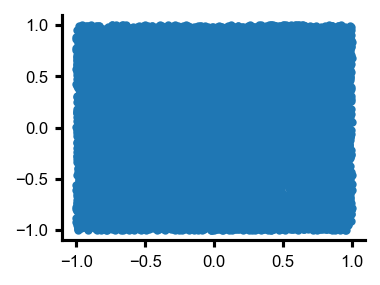

In [4]:
num_samples = 12000
uniform_samples = np.random.uniform(-1, 1, size=(num_samples, 2))
uniform_samples = torch.tensor(uniform_samples, dtype=torch.float32)

mean1, mean2 = (0.7, 0), (-.7, 0)  # Means in 2D, y-coordinate is 0 for both
variance1 = 0.04
variance2 = 0.04

# Generate samples from the mixture of 2D Gaussians
mixture_samples = np.concatenate(
    [
        np.random.multivariate_normal(
            mean1, np.diag([variance1, variance1]), num_samples // 3
        ),
        np.random.multivariate_normal(
            mean2, np.diag([variance2, variance2]), num_samples // 3*2
        ),
    ]
)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)
plt.scatter(uniform_samples[:, 0], uniform_samples[:, 1], label="Uniform")

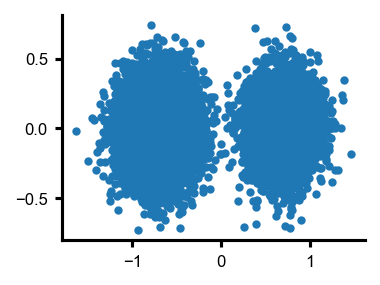

In [5]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")

In [6]:
# Fit the Gauss model to the data using sliced Wasserstein distance

# mean = torch.tensor([0.0, 0.0], requires_grad=True)
# cov = torch.tensor([[1.0 , 0.0], [0.0, 1.0]], requires_grad=True)
# mvn = torch.distributions.MultivariateNormal(torch.zeros_like(mean), torch.diag(torch.ones_like(mean)))
# data.requires_grad_()
# print(data)

gauss_model = Gauss(dim=2)

with torch.no_grad():
    samples = gauss_model.sample(num_samples)
    bandwidth = compute_rbf_mmd_median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)
optimizer = torch.optim.Adam(gauss_model.parameters(), lr=0.1)
gauss_model.train()
num_epochs = 20
for epoch in range(num_epochs):
    gauss_model.zero_grad()
    samples = gauss_model.sample(num_samples)
    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model.eval()



bandwidth:  tensor(0.0628)
Iter: 0     loss: 0.0028317468240857124
Iter: 1     loss: 0.0026132017374038696
Iter: 2     loss: 0.0023460667580366135
Iter: 3     loss: 0.0022469405084848404
Iter: 4     loss: 0.001986090559512377
Iter: 5     loss: 0.0018160156905651093
Iter: 6     loss: 0.001737288199365139
Iter: 7     loss: 0.0015592286363244057
Iter: 8     loss: 0.001450967974960804
Iter: 9     loss: 0.0013313470408320427
Iter: 10     loss: 0.0012849150225520134
Iter: 11     loss: 0.0013002967461943626
Iter: 12     loss: 0.0013061752542853355
Iter: 13     loss: 0.0013325968757271767
Iter: 14     loss: 0.0014072954654693604
Iter: 15     loss: 0.001346486620604992
Iter: 16     loss: 0.0014483612030744553
Iter: 17     loss: 0.001456654630601406
Iter: 18     loss: 0.001407652162015438
Iter: 19     loss: 0.0014006160199642181


Gauss()

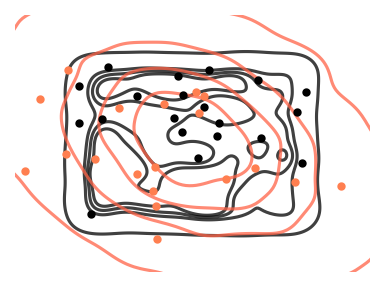

In [7]:
SWD_samples = gauss_model.sample(num_samples).detach().numpy()
# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})

# Plot the probability contours
fig,ax = plt.subplots()
sns.kdeplot(ax=ax,data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=ax,data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.tight_layout()


In [8]:
gauss_model2 = Gauss(dim=2)
with torch.no_grad():
    samples = gauss_model.sample(num_samples)
    bandwidth = compute_rbf_mmd_median_heuristic(samples,mixture_samples)
    print("bandwidth: ", bandwidth)



bandwidth:  tensor(0.0678)


In [ ]:
# Fit the Gauss model to the data using sliced Wasserstein distance

# mean = torch.tensor([0.0, 0.0], requires_grad=True)
# cov = torch.tensor([[1.0 , 0.0], [0.0, 1.0]], requires_grad=True)
# mvn = torch.distributions.MultivariateNormal(torch.zeros_like(mean), torch.diag(torch.ones_like(mean)))
# data.requires_grad_()
# print(data)
optimizer = torch.optim.Adam(gauss_model2.parameters(), lr=0.1)
gauss_model2.train()
num_epochs = 100
for epoch in range(num_epochs):
    gauss_model2.zero_grad()
    samples = gauss_model2.sample(num_samples)
    #print(samples)
    loss = compute_rbf_mmd(samples, mixture_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model2.eval()



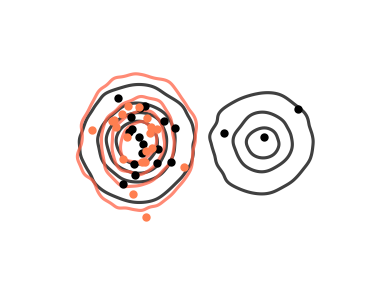

In [10]:
SWD_mix_samples = gauss_model2.sample(num_samples).detach().numpy()

mixture_df = pd.DataFrame({'x': mixture_samples[:, 0], 'y': mixture_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_mix_df = pd.DataFrame({'x': SWD_mix_samples[:, 0], 'y': SWD_mix_samples[:, 1]})

# Plot the probability contours
fig,ax = plt.subplots()
sns.kdeplot(ax=ax,data=mixture_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=ax,data=SWD_mix_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)

permuted_mix_samples = mixture_samples[torch.randperm(num_samples)]

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.0, 1.0)
ax.scatter(permuted_mix_samples[:20, 0], permuted_mix_samples[:20, 1], color="black",zorder=10)
ax.scatter(SWD_mix_samples[:20, 0], SWD_mix_samples[:20, 1], color="coral",zorder=10)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
fig.tight_layout()
#plt.savefig("MMD.png")

In [ ]:
print("SWD_mean: ",gauss_model.mean.detach().numpy())
print("SWD_cov: ",gauss_model.cov().detach().numpy())
print("uniform data mean: ",uniform_samples.mean(dim=0).numpy())
print("uniform data cov: ",uniform_samples.T.cov().numpy())

SWD_mean:  [-0.00975406  0.00832371]
SWD_cov:  [[ 0.44918722 -0.12206161]
 [-0.12206161  0.57692784]]
uniform data mean:  [-0.00267119 -0.0171042 ]
uniform data cov:  [[0.34271112 0.00867608]
 [0.00867608 0.34278804]]


In [ ]:
print("SWD_mean: ",gauss_model2.mean.detach().numpy())
print("SWD_cov: ",gauss_model2.cov().detach().numpy())
print("mixture data mean: ",mixture_samples.mean(dim=0).numpy())
print("mixture data cov: ",mixture_samples.T.cov().numpy())

SWD_mean:  [-0.26451185  0.01485614]
SWD_cov:  [[0.82529294 0.0021447 ]
 [0.0021447  0.038281  ]]
mixture data mean:  [-0.1417305   0.01251941]
mixture data cov:  [[0.53172207 0.00548582]
 [0.00548582 0.03852978]]


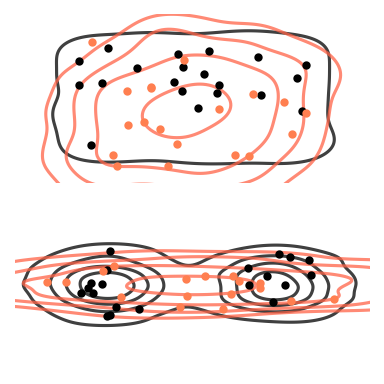

In [ ]:

params = fig_handler.get_rc(40,40)
plt.rcParams.update(params)
# Plot the probability contours
fig,axs = plt.subplots(2,1)
ax1,ax2 = axs
sns.kdeplot(ax=ax1,data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=[0.05])
sns.kdeplot(ax=ax1,data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=[0.125,0.25,0.45,0.85])

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
ax1.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
ax1.spines[['left', 'bottom']].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

sns.kdeplot(ax=ax2,data=mixture_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=ax2,data=SWD_mix_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=[0.125,0.25,0.45,0.85])

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.0, 1.0)
ax2.scatter(permuted_mix_samples[:20, 0], permuted_mix_samples[:20, 1], color="black",zorder=10,label = r"$p_{\text{true}}$")
ax2.scatter(SWD_mix_samples[:20, 0], SWD_mix_samples[:20, 1], color="coral",zorder=10,label=r"$\hat{p}_{1}$")
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")

# ax2.legend(loc="upper center")

fig.tight_layout()
fig.savefig("../../plots/swd_misspecified_models.svg")
plt.show()

params = fig_handler.get_rc(40,30)
plt.rcParams.update(params)